# Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import pylab as pl
from pyramid.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter("ignore")

# Data Import

In [26]:
data_df = pd.read_csv('./dataset.csv')
data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
print(data_df.shape)

(1117500, 24)


In [33]:
num_list = []
for i in range(24):
    num_list.append(str(i))
data_df = data_df[num_list].copy()
data_df = np.transpose(data_df)
print(data_df.shape)
print(data_df.head())

(24, 1117500)
    0         1         2         3         4         5         6        \
0  0.646860  0.661720  0.659155  0.654739  0.650966  0.647558  0.644406   
1  0.129343  0.169662  0.215704  0.259924  0.307126  0.359985  0.396063   
2  0.076145  0.055064  0.038396  0.023849  0.009120 -0.003989 -0.005928   
3  0.380201  0.446691  0.499365  0.538126  0.570946  0.594115  0.617421   
4  0.304520  0.360146  0.406218  0.431818  0.457793  0.465344  0.474053   

    7         8         9        ...   1117490   1117491   1117492   1117493  \
0  0.646484  0.646321  0.639487  ...  0.824645  0.829673  0.837201  0.845472   
1  0.425863  0.461540  0.483874  ...  0.342774  0.306161  0.263861  0.221992   
2 -0.005057 -0.008084 -0.009891  ...  0.670825  0.670482  0.673229  0.668238   
3  0.638995  0.655817  0.668538  ...  0.847527  0.842377  0.838122  0.835948   
4  0.480481  0.488802  0.493142  ...  0.437502  0.435760  0.433871  0.424543   

    1117494   1117495   1117496   1117497   1117498   

# Train-Dev-Test Split

We do not split X and Y yet.

In [5]:
indices = [20*k for k in range(55875)]
data_df = pd.DataFrame(data_df[indices])

train = []
dev = []
test1 = []
test2 = []

for i in range(data_df.shape[1]):
    tmp = data_df[20*i].copy()
    train.append(tmp[:21])
    dev.append(tmp[1:22])
    test1.append(tmp[2:23])
    test2.append(tmp[3:24])
    
train = pd.DataFrame(train)
dev = pd.DataFrame(dev)
test1 = pd.DataFrame(test1)
test2 = pd.DataFrame(test2)

train.to_csv('./train_dev_test/before_arima/train.csv')
dev.to_csv('./train_dev_test/before_arima/dev.csv')
test1.to_csv('./train_dev_test/before_arima/test1.csv')
test2.to_csv('./train_dev_test/before_arima/test2.csv')



# EDA for ARIMA modeling

### Plotting the Data

In [42]:
train.shape

(21, 55875)

9500


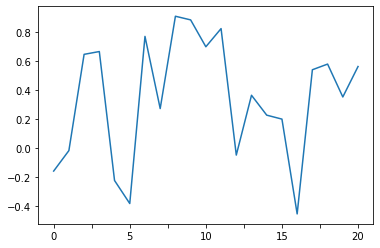

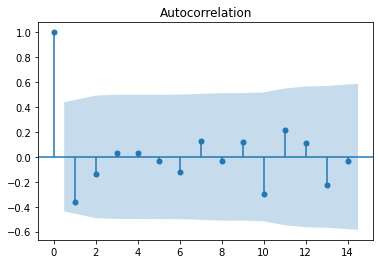

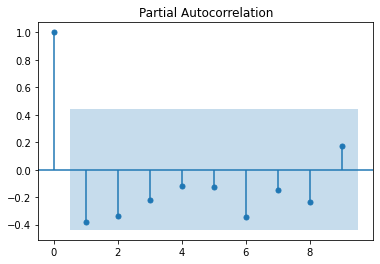

----------------------------------------------------


In [55]:
train = pd.read_csv('./train_dev_test/before_arima/train.csv')
train = np.transpose(train.loc[:, ~train.columns.str.contains('^Unnamed')])
for _ in range(100):
    randint = random.randrange(0,55875,1)
    print(randint)
    train[randint].plot()
    plt.show()
    plt.close()
    plot_acf(train[randint].diff()[1:])
    plt.show()
    plt.close()
    plot_pacf(train[randint].diff()[1:], lags = 9)
    plt.show()
    plt.close()
    print('----------------------------------------------------')
    break

In [57]:
mean = sorted(np.array(stat.iloc[1,:].copy()))
stdev = sorted(np.array(stat.iloc[2,:].copy()))
fit1 = stats.norm.pdf(mean, np.mean(mean), np.std(mean))
fit2 = stats.norm.pdf(stdev, np.mean(stdev), np.std(stdev))

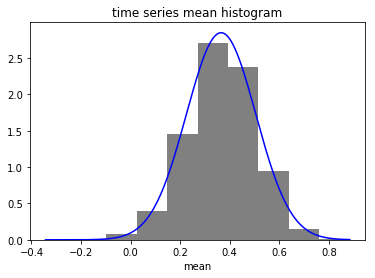

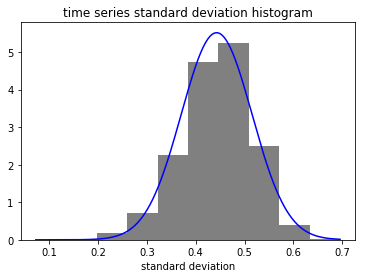

In [68]:
pl.plot(mean,fit1,color='blue')
pl.hist(mean,normed=True,color='grey')
pl.title('time series mean histogram')
pl.xlabel('mean')
pl.show()
pl.close()
pl.plot(stdev,fit2,color='blue')
pl.hist(stdev,normed=True,color='grey')
pl.title('time series standard deviation histogram')
pl.xlabel('standard deviation')
pl.show()
pl.close()

# ARIMA Modeling

In [2]:
train = pd.read_csv('./train_dev_test/before_arima/train.csv')
dev = pd.read_csv('./train_dev_test/before_arima/dev.csv')
test1 = pd.read_csv('./train_dev_test/before_arima/test1.csv')
test2 = pd.read_csv('./train_dev_test/before_arima/test2.csv')

train = np.transpose(train.loc[:,~train.columns.str.contains('^Unnamed')])
dev = np.transpose(dev.loc[:,~dev.columns.str.contains('^Unnamed')])
test1 = np.transpose(test1.loc[:,~test1.columns.str.contains('^Unnamed')])
test2 = np.transpose(test2.loc[:,~test2.columns.str.contains('^Unnamed')])

datasets = [train, dev, test1, test2]

In [3]:
model_110 = ARIMA(order=(1,1,0), method='mle', suppress_warnings=True)
model_011 = ARIMA(order=(0,1,1), method='mle', suppress_warnings=True)
model_111 = ARIMA(order=(1,1,1), method='mle', suppress_warnings=True)
model_211 = ARIMA(order=(2,1,1), method='mle', suppress_warnings=True)
model_210 = ARIMA(order=(2,1,0), method='mle', suppress_warnings=True)

train_X = []; train_Y = []
dev_X = []; dev_Y = []
test1_X = []; test1_Y = []
test2_X = []; test2_Y = []

flag = 0

for i in range(55875):
    print(i)
    tmp = []
    c=0
    for s in datasets :
        c+=1
        try:
            model1 = model_110.fit(s[i])
            model = model1
            
            try:
                model2 = model_011.fit(s[i])
                
                if model.aic() <= model2.aic() :
                    pass
                else :
                    model = model2
                    
                try :
                    model3 = model_111.fit(s[i])
                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
                    
            except:
                try:
                    model3 = model_111.fit(s[i])

                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
                
        except:
            try:
                model2 = model_011.fit(s[i])
                model = model2
            
                try :
                    model3 = model_111.fit(s[i])
                    
                    if model.aic() <= model3.aic():
                        pass
                    else:
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
            
            except :
                try:
                    model3 = model_111.fit(s[i])
                    model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            flag = 1
                            print(str(c) + " FATAL ERROR")
                            break
        
        predictions = list(model.predict_in_sample())
        #pad the first time step of predictions with the average of the prediction values
        #so as to match the length of the s[i] data
        predictions = [np.mean(predictions)] + predictions
        
        residual = pd.Series(np.array(s[i]) - np.array(predictions))
        tmp.append(np.array(residual))
        
                    
    if flag == 1:
        break
    train_X.append(tmp[0][:20])
    train_Y.append(tmp[0][20])
    dev_X.append(tmp[1][:20])
    dev_Y.append(tmp[1][20])
    test1_X.append(tmp[2][:20])
    test1_Y.append(tmp[2][20])
    test2_X.append(tmp[3][:20])
    test2_Y.append(tmp[3][20])

1
52542
52543
52544
52545
52546
52547
52548
52549
52550
52551
52552
52553
52554
52555
52556
52557
52558
52559
52560
52561
52562
52563
52564
52565
52566
52567
52568
52569
52570
52571
52572
52573
52574
52575
52576
52577
52578
52579
52580
52581
52582
52583
52584
52585
52586
52587
52588
52589
52590
52591
52592
52593
52594
52595
52596
52597
52598
52599
52600
52601
52602
52603
52604
52605
52606
52607
52608
52609
52610
52611
52612
52613
52614
52615
52616
52617
52618
52619
52620
52621
52622
52623
52624
52625
52626
52627
52628
52629
52630
52631
52632
52633
52634
52635
52636
52637
52638
52639
52640
52641
52642
52643
52644
52645
52646
52647
52648
52649
52650
52651
52652
52653
52654
52655
52656
52657
52658
52659
52660
52661
52662
52663
52664
52665
52666
52667
52668
52669
52670
52671
52672
52673
52674
52675
52676
52677
52678
52679
52680
52681
52682
52683
52684
52685
52686
52687
52688
52689
52690
52691
52692
52693
52694
52695
52696
52697
52698
52699
52700
52701
52702
52703
52704
52705
52706
52707
52

In [4]:
pd.DataFrame(train_X).to_csv('./train_dev_test/after_arima/train_X.csv')
pd.DataFrame(dev_X).to_csv('./train_dev_test/after_arima/dev_X.csv')
pd.DataFrame(test1_X).to_csv('./train_dev_test/after_arima/test1_X.csv')
pd.DataFrame(test2_X).to_csv('./train_dev_test/after_arima/test2_X.csv')
pd.DataFrame(train_Y).to_csv('./train_dev_test/after_arima/train_Y.csv')
pd.DataFrame(dev_Y).to_csv('./train_dev_test/after_arima/dev_Y.csv')
pd.DataFrame(test1_Y).to_csv('./train_dev_test/after_arima/test1_Y.csv')
pd.DataFrame(test2_Y).to_csv('./train_dev_test/after_arima/test2_Y.csv')


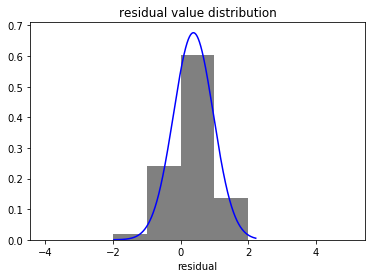

0.0022371364653243847 % of the data is out of bound [-2,2]
15.579686800894855 % of the data is out of bound [-1,1]


In [10]:
train = pd.read_csv('./train_dev_test/after_arima/train_X.csv')
train = np.transpose(train.loc[:,~train.columns.str.contains('^Unnamed')])
train_melt = sorted(np.array(train.melt()['value']))
fit = stats.norm.pdf(train_melt, np.mean(train_melt), np.std(train_melt))
pl.hist(train_melt,normed=True, color='grey', bins=[-4,-3,-2,-1,0,1,2,3,4,5])
pl.plot(train_melt,fit,color='blue')
pl.title('residual value distribution')
pl.xlabel('residual')
pl.show()
pl.close()

X = [x for x in train_melt if x>2]
Y = [y for y in train_melt if y<-2]
out_of_bound = X + Y
print(str(len(out_of_bound)/11175) +' % of the data is out of bound [-2,2]')

X = [x for x in train_melt if x>1]
Y = [y for y in train_melt if y<-1]
out_of_bound = X + Y
print(str(len(out_of_bound)/11175) +' % of the data is out of bound [-1,1]')

In [6]:
stat = pd.DataFrame()
for i in range(55875):
    df = train[i].describe()
    stat[i] = df
stat

,0,1,2,3,4,5,6,7,8,9,...,55865,55866,55867,55868,55869,55870,55871,55872,55873,55874
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.465135,0.478827,0.487521,0.512928,0.442817,0.412005,0.428373,0.434012,0.503504,0.557647,...,0.539199,0.463905,0.438401,0.475653,0.696424,0.479424,0.435439,0.486763,0.538542,0.591129
std,0.419184,0.589537,0.518267,0.547934,0.524444,0.634964,0.731018,0.713091,0.635519,0.553945,...,0.477433,0.634603,0.631755,0.564362,0.317755,0.481425,0.623488,0.547647,0.421620,0.330468
min,-0.263326,-0.871317,-0.632723,-0.457728,-0.669352,-1.192555,-0.798683,-0.992424,-0.749328,-0.693762,...,-0.284182,-1.081752,-0.830846,-0.769261,-0.157673,-0.445382,-0.653030,-0.343247,-0.217465,-0.144106
25%,0.137162,0.057120,0.104796,0.176821,0.290499,0.046377,-0.205282,0.040316,0.065659,0.347011,...,0.150459,0.092596,0.212232,0.268854,0.588856,0.107534,-0.030239,-0.023476,0.239889,0.433625
50%,0.432705,0.550390,0.595463,0.528942,0.538972,0.446580,0.758014,0.457777,0.365164,0.469732,...,0.521219,0.681396,0.641277,0.757338,0.767079,0.452052,0.539760,0.581970,0.627348,0.563944
75%,0.758976,0.936980,0.824544,0.832151,0.744445,0.853692,0.888631,1.011853,0.970546,0.855817,...,0.952435,0.911948,0.839470,0.794109,0.900668,0.855510,0.941595,0.968518,0.922975,0.809965
max,1.115144,1.253518,1.216251,1.503089,1.320323,1.390179,1.578179,1.539877,1.390272,1.459066,...,1.236973,1.273152,1.248403,1.261881,1.163793,1.262085,1.309751,1.206766,1.155250,1.175434
